In [1]:
import pm4py
from pm4py.objects.process_tree import semantics

## Generate PT

In [3]:
'''
    This file is part of PM4Py (More Info: https://pm4py.fit.fraunhofer.de).

    PM4Py is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    PM4Py is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with PM4Py.  If not, see <https://www.gnu.org/licenses/>.
'''
from pm4py.objects.process_tree import obj
from pm4py.objects.process_tree import obj as pt_operator
from scipy.stats import triang as triangular
import string
import math
import itertools
from enum import Enum
from itertools import accumulate as _accumulate, repeat as _repeat
from bisect import bisect as _bisect
import random


def choices(population, weights=None, *, cum_weights=None, k=1):
    """Return a k sized list of population elements chosen with replacement.
    If the relative weights or cumulative weights are not specified,
    the selections are made with equal probability.
    """
    n = len(population)
    if cum_weights is None:
        if weights is None:
            _int = int
            n += 0.0    # convert to float for a small speed improvement
            return [population[_int(random.random() * n)] for i in _repeat(None, k)]
        cum_weights = list(_accumulate(weights))
    elif weights is not None:
        raise TypeError('Cannot specify both weights and cumulative weights')
    if len(cum_weights) != n:
        raise ValueError('The number of weights does not match the population')
    bisect = _bisect
    total = cum_weights[-1] + 0.0   # convert to float
    hi = n - 1
    return [population[bisect(cum_weights, random.random() * total, 0, hi)]
            for i in _repeat(None, k)]



class Parameters(Enum):
    SEQUENCE = "sequence"
    CHOICE = "choice"
    PARALLEL = "parallel"
    OR = "or"
    MODE = "mode"
    MIN = "min"
    MAX = "max"
    SILENT = "silent"
    DUPLICATE = "duplicate"
    LT_DEPENDENCY = "lt_dependency"
    INFREQUENT = "infrequent"
    NO_MODELS = "no_models"
    UNFOLD = "unfold"
    MAX_REPEAT = "max_repeat"



def apply(parameters=None):
    """
    Generate a process tree using the PTAndLogGenerator approach
    (see the paper PTandLogGenerator: A Generator for Artificial Event Data)

    Parameters
    --------------
    parameters
        Parameters of the algorithm, according to the paper:
        - Parameters.MODE: most frequent number of visible activities
        - Parameters.MIN: minimum number of visible activities
        - Parameters.MAX: maximum number of visible activities
        - Parameters.SEQUENCE: probability to add a sequence operator to tree
        - Parameters.CHOICE: probability to add a choice operator to tree
        - Parameters.PARALLEL: probability to add a parallel operator to tree
        - Parameters.LOOP: probability to add a loop operator to tree
        - Parameters.OR: probability to add an or operator to tree
        - Parameters.SILENT: probability to add silent activity to a choice or loop operator
        - Parameters.DUPLICATE: probability to duplicate an activity label
        - Parameters.LT_DEPENDENCY: probability to add a random dependency to the tree
        - Parameters.INFREQUENT: probability to make a choice have infrequent paths
        - Parameters.NO_MODELS: number of trees to generate from model population
        - Parameters.UNFOLD: whether or not to unfold loops in order to include choices underneath in dependencies: 0=False, 1=True
            if lt_dependency <= 0: this should always be 0 (False)
            if lt_dependency > 0: this can be 1 or 0 (True or False)
        - Parameters.MAX_REPEAT: maximum number of repetitions of a loop (only used when unfolding is True)
    """
    if parameters is None:
        parameters = {}

    if not "mode" in parameters:
        parameters["mode"] = 30
    if not "min" in parameters:
        parameters["min"] = 30
    if not "max" in parameters:
        parameters["max"] = 50
    if not "sequence" in parameters:
        parameters["sequence"] = 0.25
    if not "choice" in parameters:
        parameters["choice"] = 0.25
    if not "parallel" in parameters:
        parameters["parallel"] = 0.25
    if not "or" in parameters:
        parameters["or"] = 0.25
    if not "silent" in parameters:
        parameters["silent"] = 0
    if not "duplicate" in parameters:
        parameters["duplicate"] = 0
    if not "lt_depencency" in parameters:
        parameters["lt_depencency"] = 0.0
    if not "infrequent" in parameters:
        parameters["infrequent"] = 0.5
    if not "no_models" in parameters:
        parameters["no_models"] = 10
    if not "unfold" in parameters:
        parameters["unfold"] = 10
    if not "max_repeat" in parameters:
        parameters["max_repeat"] = 10

    return GeneratedTree(parameters).generate()

def assign_operator(operator):
    if operator == "choice":
        return pt_operator.Operator.XOR
    elif operator == "sequence":
        return pt_operator.Operator.SEQUENCE
    elif operator == "parallel":
        return pt_operator.Operator.PARALLEL
    elif operator == "or":
        return pt_operator.Operator.OR
    else:
        return None



class GeneratedTree(object):
    # are later used as labels
    alphabet = string.ascii_lowercase

    def calculate_activity_distribution(self, mode, min, max):
        """
        Here, the triangular function is used, since the parameters for this function are given in the paramterfile.
        However, this approach can be applied on other distribution functions as well.
        :param mode: Mode of the distribution
        :param min: Smallest number
        :param max: Highest number
        :return: Distribution object
        """
        c = (mode - min) / (max - min)
        return triangular(c, loc=min, scale=max - min)


    def draw_random_number_from_distribution(self):
        return self.activity_distribution.rvs(1)[0]


    def select_operator(self):
        # add root operator, if probabilities are high enough
        # ordering of operator computation is sequence, choice, parallel, loop, or
        operator = choices(["sequence", "choice", "parallel","or"],
                                  [self.parameters["sequence"], self.parameters["choice"], self.parameters["parallel"],
                                   self.parameters["or"]])
        return operator[0]


    def get_next_activity(self, activity):
        result = self.set_activity_labels[self.set_activity_labels.index(activity) + 1]
        return result


    def assign_root_opeartor(self):
        activity = "a"
        # is a silent activity chosen
        silent_activity = False
        if random.random() < self.parameters["silent"]:
            silent_activity = True
        root = self.tree._get_root()
        operator = self.select_operator()
        root.operator = assign_operator(operator)
        # if operator is loop, we use a special structure, otherwise 2
        if operator == "loop":
            print('POPO')
        else:
            if silent_activity and operator == "choice":
                number = random.choice([0, 1])
                if number == 0:
                    new_node = obj.ProcessTree(label=None)
                    new_node.parent = root
                    root._children.append(new_node)
                    new_node = obj.ProcessTree(label=activity)
                    new_node.parent = root
                    root._children.append(new_node)
                else:
                    new_node = obj.ProcessTree(label=activity)
                    new_node.parent = root
                    root._children.append(new_node)
                    new_node = obj.ProcessTree(label=None)
                    new_node.parent = root
                    root._children.append(new_node)
            else:
                new_node = obj.ProcessTree(label=activity)
                new_node.parent = root
                root._children.append(new_node)
                activity = self.get_next_activity(activity)
                new_node = obj.ProcessTree(label=activity)
                new_node.parent = root
                root._children.append(new_node)
        # always two children are added
        self.total_activities -= 2
        return self.get_next_activity(activity)


    def add_node(self, next_activity):
        """
        Add nodes to current tree. The general procedure is as follows:
        Select a random leaf (leaves have label). Next step, and opertor is chosen.
        The chosen operator then replaces the leaf, whereby the old label is then add as a leaf to the manipulated node.
        Then, next activity is added as a second leaf to the new operator node or a silent acticity (tau) is added.
        :return: Next activity
        """
        # Need to select random node that is not a silent activity
        leaf_silent = True
        while (leaf_silent):
            leaf = random.choice(self.tree._get_leaves())
            if leaf.label is not None:
                leaf_silent = False
        operator_nok = True
        while (operator_nok):
            operator = self.select_operator()
            if self.total_activities > 1:
                operator_nok = False
            else:
                if operator != "loop":
                    operator_nok = False
        activity = leaf._get_label()
        leaf._set_label(None)
        leaf._set_operator(assign_operator(operator))
        # Will be an tau added?
        silent_activity = False
        if random.random() < self.parameters["silent"]:
            silent_activity = True
        # add two children
        if operator == "loop":
            print('popo')
        else:
            if silent_activity and operator == "choice":
                number = random.choice([0, 1])
                if number == 0:
                    new_node = obj.ProcessTree(label=None)
                    new_node.parent = leaf
                    leaf._children.append(new_node)
                    new_node = obj.ProcessTree(label=activity)
                    new_node.parent = leaf
                    leaf._children.append(new_node)
                else:
                    new_node = obj.ProcessTree(label=activity)
                    new_node.parent = leaf
                    leaf._children.append(new_node)
                    new_node = obj.ProcessTree(label=None)
                    new_node.parent = leaf
                    leaf._children.append(new_node)
            else:
                new_node = obj.ProcessTree(label=activity)
                new_node.parent = leaf
                leaf._children.append(new_node)
                activity = next_activity
                new_node = obj.ProcessTree(label=activity)
                new_node.parent = leaf
                leaf._children.append(new_node)

        self.total_activities -= 2
        if silent_activity and operator == "choice":
            return next_activity
        else:
            return self.get_next_activity(activity)


    def add_duplicates(self):
        """
        Replaces some leaves  to add duplicated labels. Depends on parameter.
        :return:
        """
        duplication_allowed = False
        leaves = self.tree._get_leaves()
        for leaf in leaves:
            if leaf._parent != self.tree._get_root():
                duplication_allowed = True
                break
        # if there is at least a depth of two
        if duplication_allowed:
            # list that contains the leaves with a label unequal to tau
            leaves_with_label = []
            for leaf in leaves:
                if leaf.label is not None:
                    leaves_with_label.append(leaf)
            # generate random list of duplicates
            duplicates = []
            for leaf in leaves:
                if random.random() < self.parameters["duplicate"]:
                    duplicates.append(leaf)
            if len(duplicates) > 0:
                # select potential leaves to replace them by duplicates
                possible_replacements = []
                for leaf in leaves:
                    if leaf not in duplicates:
                        possible_replacements.append(leaf)
            for leaf in duplicates:
                i = 0
                siblings = []
                # determine sibling nodes (same parent)
                p = leaf._parent
                for child in p._children:
                    if child != leaf:
                        siblings.append(child)
                # TODO Skaling? Original: 30times, my idea : percentage of duplicates * len(leaves)
                while i < self.parameters["duplicate"] * len(leaves):
                    replacement = random.choice(possible_replacements)
                    if replacement not in siblings:
                        replacement._label = leaf._label
                        break


    def create_process_tree(self):
        self.tree = obj.ProcessTree()
        self.set_activity_labels = []
        p = 1
        # create labels
        while (self.total_activities > len(self.set_activity_labels)):
            # pairwise product
            l = itertools.product(self.alphabet, repeat=p)
            for item in l:
                label = ""
                for element in item:
                    label += str(element)
                self.set_activity_labels.append(label)
            p += 1
        step = 1
        activity = self.assign_root_opeartor()
        step += 1

        while (self.total_activities > 0):
            activity = self.add_node(activity)
            step += 1


    def __init__(self, parameters):
        self.parameters = {}
        for param in parameters:
            p = param if type(param) is str else param.value
            self.parameters[p] = parameters[param]
        # rescale probabilities of operators if the sum is not equal to one
        if self.parameters["sequence"] + self.parameters["choice"] + self.parameters["parallel"] + self.parameters["or"] != 1:
            sum_of_operators = self.parameters["sequence"] + self.parameters["choice"] + self.parameters["parallel"] + \
                               self.parameters["or"]
            self.parameters["sequence"] = self.parameters["sequence"] / sum_of_operators
            self.parameters["choice"] = self.parameters["choice"] / sum_of_operators
            self.parameters["parallel"] = self.parameters["parallel"] / sum_of_operators
            self.parameters["or"] = self.parameters["or"] / sum_of_operators
        # First step: Compute acivity distribution
        # Since mode, min and max are given, the triangle distribution is chosen
        self.activity_distribution = self.calculate_activity_distribution(self.parameters["mode"],
                                                                          self.parameters["min"],
                                                                          self.parameters["max"])
        # Number of total activities represented in the tree. Also, tau is counted as an activity.
        self.total_activities = int(math.ceil(self.draw_random_number_from_distribution()))


    def generate(self):
        # Create a process tree based on the given probabilities
        self.create_process_tree()
        # add duplicates
        self.add_duplicates()

        return self.tree

O( +( O( ->( 'a', 'm' ), O( 'f', ->( 'h', 'i' ) ) ), 'c' ), ->( 'b', X( X( X( O( X( O( 'd', 'q' ), 'o' ), 'l' ), O( O( 'k', ->( 'p', 'r' ) ), 'n' ) ), 'g' ), +( 'e', 'j' ) ) ) )


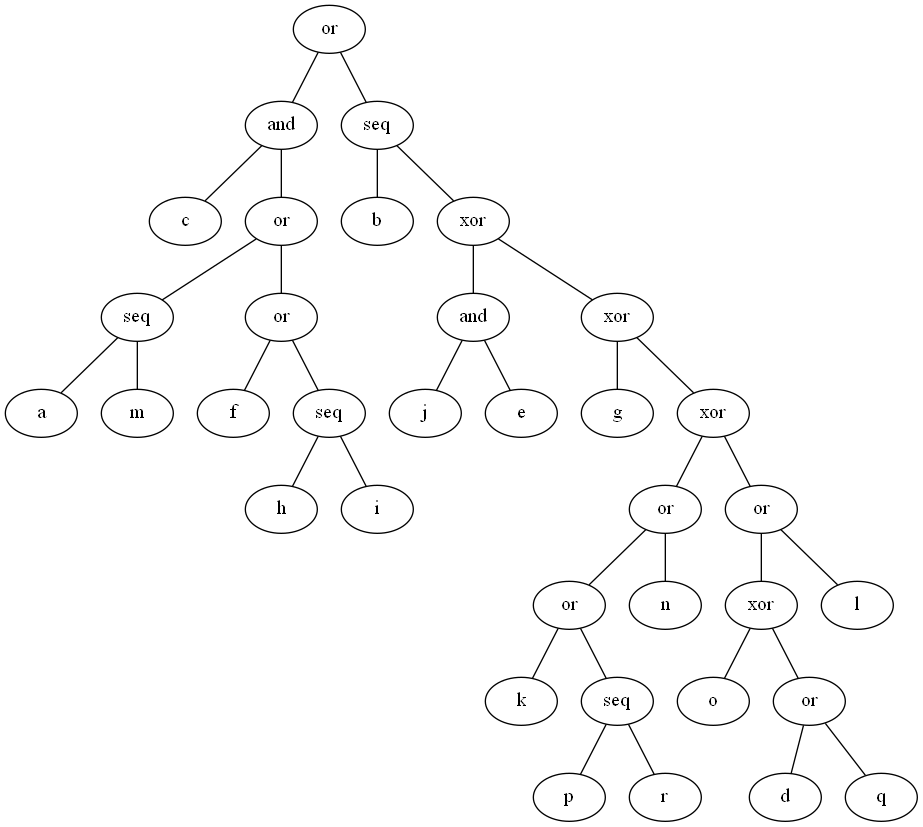

exporting log, completed traces ::   0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
nl = apply()
print(nl)
pm4py.view_process_tree(nl,"png")
pm4py.objects.process_tree.exporter.exporter.apply(nl, "ptree3.xml")

net, im, fm = pm4py.convert_to_petri_net(nl)
log = pm4py.play_out(net, im, fm)
#log = pm4py.play_out(thept)
#log = semantics.generate_log(nl, no_traces=5)
pm4py.write_xes(log, 'processtraces.xes')


## Translate PT into AT

In [ ]:
import copy
import graphviz
import uuid
import Node as nd
import xml.etree.cElementTree as ET
from IPython import display
import pm4py
import sys


count = 0
# Translate the Process Tree into an Attack Tree
def P2T(node):
	global count
    # If our current node is an operator
	if not node.operator == None:
		print(node.operator)
		#Create the new node
		parent = nd.Node('tau' + str(count), 'non-observable')
		#DFS on all children
		for child in node.children:
				count = count + 1
				new = P2T(child)
				if new == None:
					continue

			    #Set the relationship(SAND, AND, OR, XOR)
			    #SEQUENCE -> SAND
			    #PARALLEL -> AND
			    #OR       -> OR
			    #XOR      -> XOR
			    #LOOP     -> ?
				new.setParentRelationship(node.operator.name)
				if new.getName() != None:
					attckTreebranch = copy.deepcopy(new)
					attckTreebranch.setID(uuid.uuid4().hex)
					parent.setChildren(attckTreebranch)

		#newp = copy.deepcopy(parent)
		#newp.setID(uuid.uuid4().hex)
		return copy.deepcopy(parent)

    #If our current node is not an operator
	elif node.label != '0':
		print(node.label)
		return nd.Node(node.label, 'observable')

# Convert to xml
# Save the attack tree (bfs access)
def AT2xml(node, filepath):
	tree = ET.Element("tree")
	if node is None:
		return
	queue = [node]
	while len(queue) > 0:
		cur_node = queue.pop(0)
		ET.SubElement(tree, "root", name =cur_node.getName(), state =  "observable", id = cur_node.getID())
		for child in cur_node.getChildren():
			ET.SubElement(tree, "child", name = child.getName(), state =  "observable", parentRelationship = child.getParentRelationship(), parent = cur_node.getID(), id=child.getID())
			queue.append(child)
	ET.ElementTree(tree).write(filepath+".xml")

def Tree2RisQFLan(root, file):
	with open(file, 'w') as file:
		file.write('begin model Empty \n// This is an empty RisQFLan file \n// Fill all the blocks to model your scenario name \n//Here we specify variables and their initial values. This is convenient to express constraints and to ease the analysis\nbegin variables \nend variables \n// Here we specify all the things that can go wrong\n// In particular successful actions of attacker\nbegin attack nodes\n')
		queue = [root]
		while len(queue) > 0:
			cur_node = queue.pop(0)
			file.write(cur_node.getName() + '\n')
			for child in cur_node.getChildren():
				queue.append(child)
		file.write('end attack nodes\n')
		file.write('// Reactive defensive actions\nbegin defense nodes\nend defense nodes\n// Permanent defensive actions\nbegin countermeasure nodes\nend countermeasure nodes\n// The diagram specifies how defensive actions and attacker actions relate to each other\nbegin attack diagram\n')
		queue = [root]
		while len(queue) > 0:
			cur_node = queue.pop(0)
			if len(cur_node.getChildren()) == 0:
				continue
			file.write(cur_node.getName())
			flag = False
			for child in cur_node.getChildren():
				if(not flag):
					operator = child.getParentRelationship()
					if operator == 'SeqAnd':
						file.write(' -OAND-> [')
					elif operator == 'And':
						file.write(' -AND-> {')
					elif operator == 'Or':
						file.write(' -> {')
					elif operator == 'Xor':
						file.write(' -K1-> {')
					else:
						print('no operator')

					flag = True
				else:
					file.write(', ')
				file.write(child.getName())
				queue.append(child)
			if(flag):
				if operator == 'SeqAnd':
					file.write(']\n')
				elif operator == 'And':
					file.write('}\n')
				elif operator == 'Or':
					file.write('}\n')
				elif operator == 'Xor':
					file.write('}\n')
				else:
					continue
		file.write('end attack diagram\n')
		file.write('// Here we can specify classes of attackers with probabilistic behavior\nbegin attackers\n attacker1\nend attackers\n// The effectiveness of a defence depends on the class of attacker and the attack action\nbegin defense effectiveness\nend defense effectiveness\n// Attacks may not be detected \nbegin attack detection rates\nend attack detection rates\n// Attributes of attacks are specified here\nbegin attributes\nend attributes\n// One can here impose additional constraints on the attacker, e.g. based on his budget\nbegin quantitative constraints\nend quantitative constraints\n//Domain-specific actions executed by the attacker\nbegin actions\nend actions\n//Constraints on the execution of actions\nbegin action constraints\nend action constraints\n//The probabilistic behaviour of each attacker\nbegin attacker behaviour\nbegin attack attacker\n= attacker1\nstates = state1\ntransitions = \n	state1 - (succ(' + root.getName() +'),1.0) -> state1\nend attack \nend attacker behaviour\n// Here we specify the attacker we want to consider\nbegin init\nattacker1\nend init\n//Finally, you can specify 3 types of analysis\n//analysis: statistical analysis of quantitative properties\n//exportDTMC: export the state space of the model (if finite) in a discrete time Markov chain in the format supported by the model checkers PRISM and STORM\n//simulate: perform a simulation to debug your model\n\n// In this particular case we are just interested in the likelihood of success of each attack\nbegin analysis\n   query = eval from 1 to 100 by 20 :\n    {'     + root.getName() +    '\n}\n    // Statistical confidence\n    default delta = 0.1\n    alpha = 0.1\n    // Parallelism to be exploited in the machine \n    parallelism = 1\nend analysis\nend model')


#def main(filei, fileo):
# import the process tree
# ProcessTree = pm4py.objects.process_tree.importer.importer.apply("ptree3.xml")

#Translate to Attack Tree
AttackTree = P2T(nl)
print("Attack tree translated!")

#Write Attck Tree to xml
AT2xml(AttackTree, "atree")

#Convert to RISQFlan code
Tree2RisQFLan(AttackTree, "atree" + ".bbt")
print("Attack tree converted to RISQFlan code!")



## Replay PT traces in AT

In [ ]:
from pm4py.objects.log.importer.xes import importer as xes_importer

In [ ]:
#update the values in nodes
def dfs(element, node):
    if node == None:
        return
    
    if node.getName() == element:
        node.updateValue(1)
        return
    
    for child in node.getChildren():
        dfs(element, child)
        
    return

#clear the values in nodes
def clear(node):
    if node == None:
        return
    
    for child in node.getChildren():
        clear(child)
    
    node.updateValue(0)

    return

#Check the value of the node
def check(node):
    
    if len(node.getChildren()) == 0:
        return 
    
    relation = node.getChildren()[0].getParentRelationship()
    
    value = 0
    
    check_xor = 0
    
    check_seq = 0

    for child in node.getChildren():
        check(child)
        value = value + child.getValue()

    if relation == 'Or':
        if value > 0:
            node.updateValue(1)
            
    if relation == 'Xor':
        for child in node.getChildren():
            check_xor = check_xor + child.getValue()
        if(check_xor == 1):
            node.updateValue(1)
        check_xor = 0
    
    if relation == 'And':
        if value == len(node.getChildren()):
            node.updateValue(1)
            
    if relation == 'SeqAnd':
        for i in range(0,len(node.getChildren())):
            if i==0:
                if node.getChildren()[0].getValue() == 1:
                    check_seq = check_seq + 1
            else:
                if(i == check_seq):
                    check_seq = check_seq + 1
                    
        if(check_seq == len(node.getChildren())):
            node.updateValue(1)
        #print('check seq', check_seq)
        
        check_seq = 0
            
        
    return

# Replay the traces on the Attack Tree
def replay(trace):
    #print(trace)
    for element in trace:
        dfs(element, AttackTree)
    check(AttackTree)
    return AttackTree.getValue()

In [ ]:
log = xes_importer.apply("processtraces.xes")
x = 0
for trace in log:
    tracetocheck = []
    for event in trace:
        tracetocheck.append(event.get("concept:name"))
    #print(tracetocheck)
    #print(trace.attributes, replay(tracetocheck))
    x =  x + replay(tracetocheck)
    clear(AttackTree)
x = int(x)
print(x)
print(x/len(log))